# Make moons

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import einops
import numpy as np

In [378]:
import flax.linen as nn

In [440]:
from sklearn.datasets import make_moons, make_biclusters
from rebayes_mini import callbacks

from rebayes_mini.methods import robust_filter as rf
from rebayes_mini.methods import gauss_filter as gf

In [388]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [389]:
%config InlineBackend.figure_format = "retina"

In [390]:
key = jax.random.PRNGKey(314)
key_train, key_corrupt, key_pos = jax.random.split(key, 3)

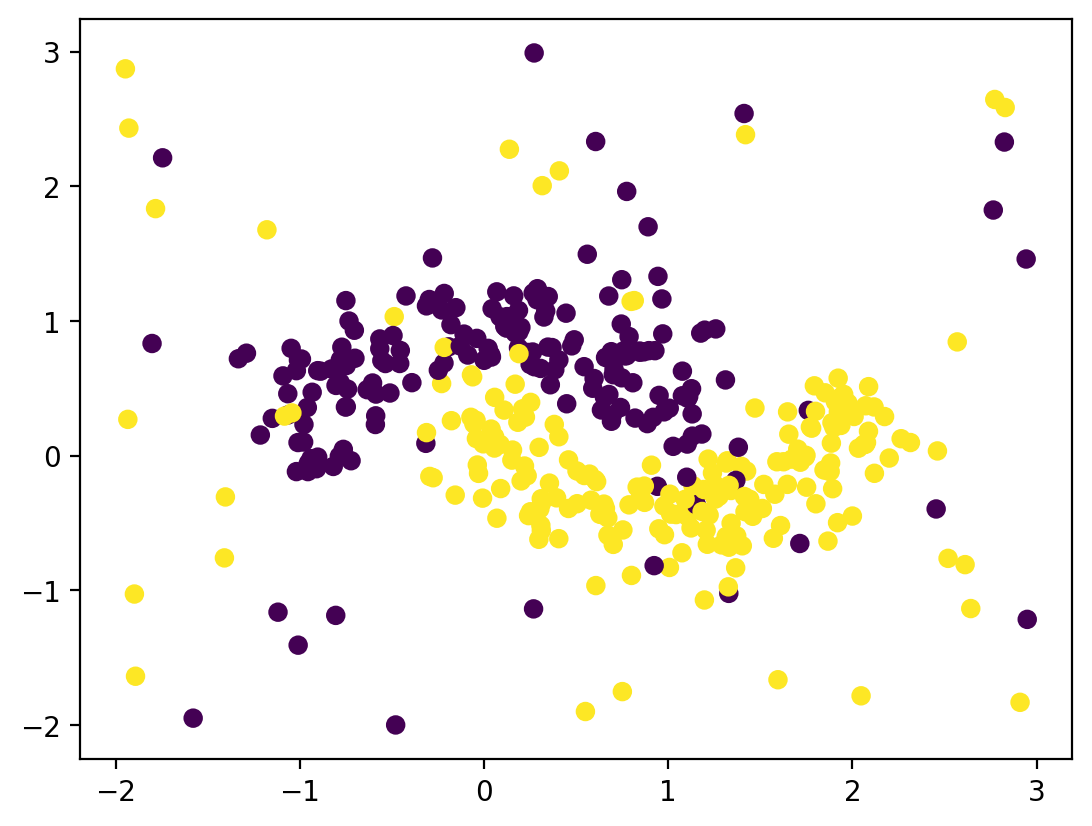

In [750]:
n_samples = 400
n_test = 200
data = make_moons(n_samples=n_samples, noise=0.2, random_state=314)
data_test = make_moons(n_samples=n_test, noise=0.2, random_state=271)
X, y = jax.tree_map(jnp.array, data)
y = y.astype(float)
X_test, y_test = jax.tree_map(jnp.array, data_test)
y_test = y_test.astype(float)


# data = make_biclusters(shape=(n_samples, 2), n_clusters=2, noise=0.5, random_state=314, minval=-2, maxval=2)[:-1]
# data_test = make_biclusters(shape=(n_test, 2), n_clusters=2, noise=0.5, random_state=271, minval=-2, maxval=2)[:-1]
# X, y = jax.tree_map(jnp.array, data)
# X_test, y_test = jax.tree_map(jnp.array, data_test)
# y_test = y_test.astype(float).argmax(axis=0)
# y = y.astype(float).argmax(axis=0)


corrupt_map = jax.random.uniform(key_corrupt, shape=y.shape) < 0.15
corrupt_vals = jax.random.uniform(key_pos, shape=X.shape, minval=-2, maxval=3.0)
corrupt_where = jnp.where(corrupt_map)

X = X.at[corrupt_where].set(corrupt_vals[corrupt_where])
y = y.at[corrupt_where].set(1 - y[corrupt_where])


plt.scatter(*X.T, c=y)

In [751]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = jnp.sin(x)
        # x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        # x = jnp.sin(x)
        x = nn.Dense(1)(x)
        return x # Eta
    
model = MLP()
params = model.init(key, X)

# Vanilla filter

In [795]:
agent = gf.BernoulliFilter(
    model.apply,
    dynamics_covariance=0.0
)

# bel_init = agent.init_bel(params, cov=2.5)
bel_init = agent.init_bel(params, cov=0.5)
bel, bel_hist = agent.scan(bel_init, y, X)

In [796]:
eta = agent.link_fn(bel.mean, X)
yhat = jax.nn.sigmoid(eta) > 0.5
yhat = yhat.squeeze().astype(float)

In [797]:
(y == yhat.squeeze()).mean()

Array(0.76, dtype=float32)

### Test eval

In [798]:
eta_test = agent.link_fn(bel.mean, X_test)
yhat_test = jax.nn.sigmoid(eta_test) > 0.5
yhat_test = yhat_test.squeeze().astype(float)

In [799]:
(y_test == yhat_test.squeeze()).mean()

Array(0.77, dtype=float32)

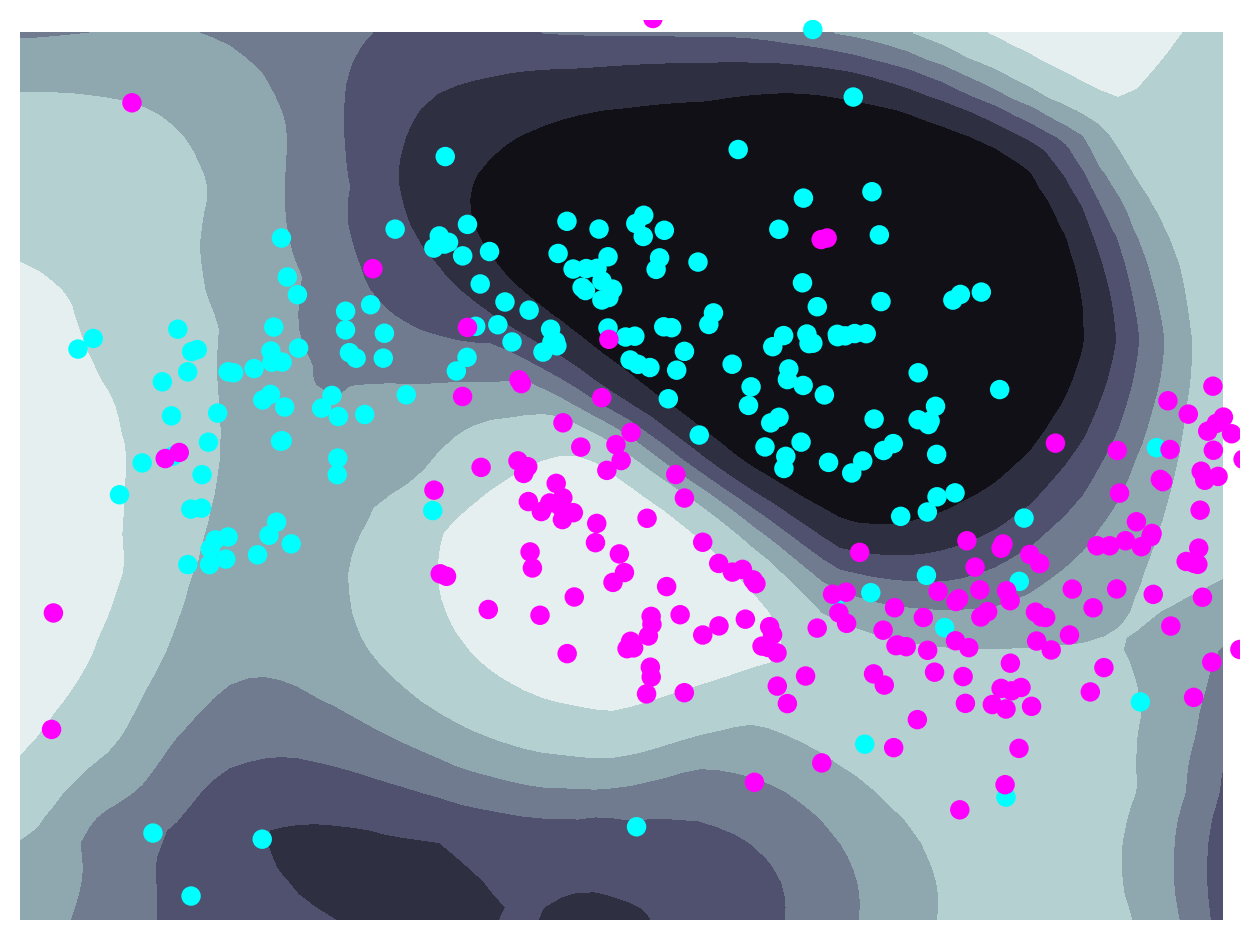

In [800]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="bone")
# plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
# plt.contour(*XX, mean_Z, cmap="bone")
plt.scatter(*np.array(X).T, c=y, cmap="cool")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

# Robust filter

In [778]:
agent = rf.RobustBernoulliFilter(
    model.apply,
    dynamics_covariance=0.0,
    c=1.0
)

# bel_init = agent.init_bel(params, cov=2.5)
bel_init = agent.init_bel(params, cov=0.5)
bel, bel_hist = agent.scan(bel_init, y, X)

In [779]:
eta = agent.link_fn(bel.mean, X)
yhat = jax.nn.sigmoid(eta) > 0.5
yhat = yhat.squeeze().astype(float)

In [780]:
(y == yhat.squeeze()).mean()

Array(0.9025, dtype=float32)

### Test eval

In [781]:
eta_test = agent.link_fn(bel.mean, X_test)
yhat_test = jax.nn.sigmoid(eta_test) > 0.5
yhat_test = yhat_test.squeeze().astype(float)

In [782]:
(y_test == yhat_test.squeeze()).mean()

Array(0.96999997, dtype=float32)

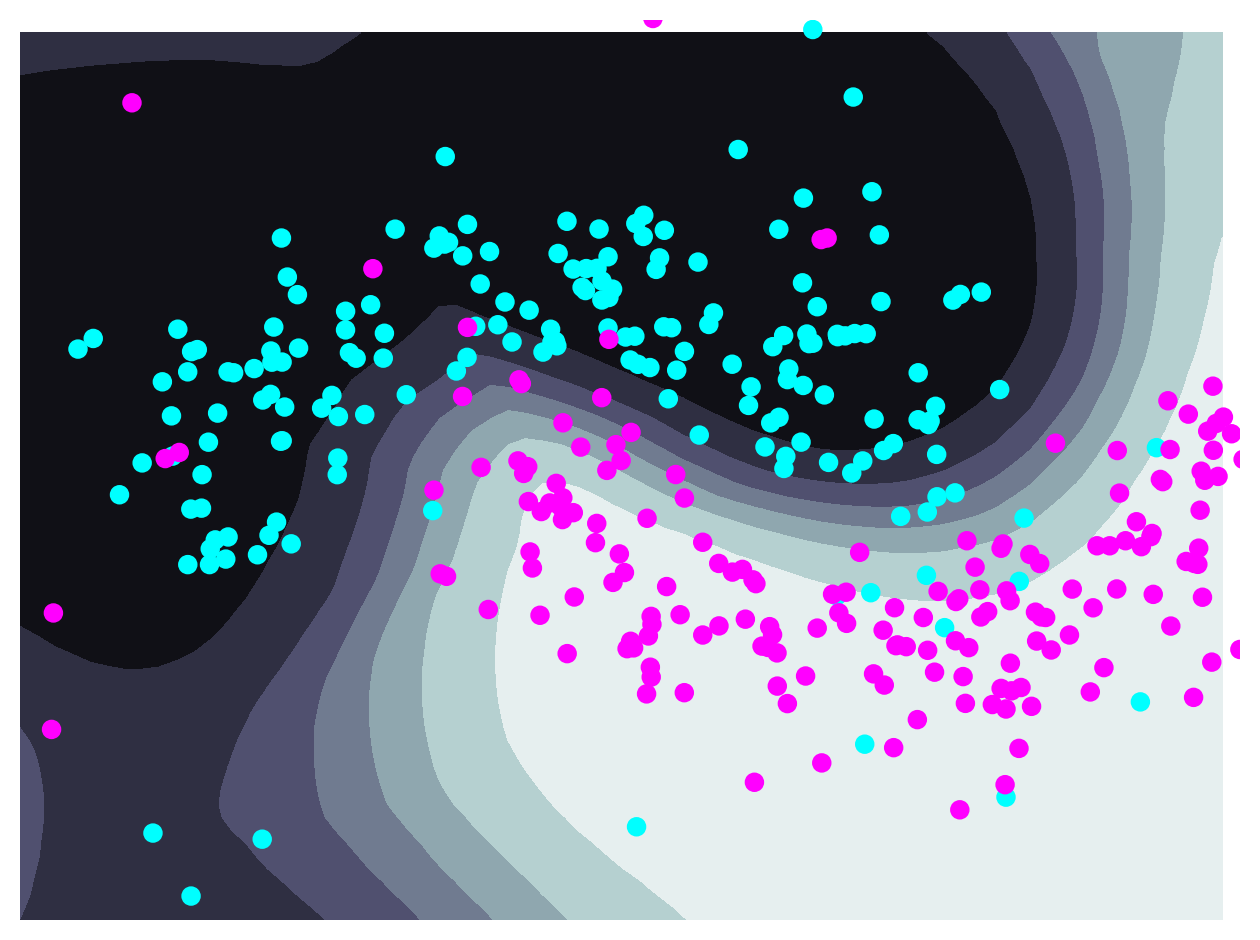

In [789]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="bone")
# plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
plt.scatter(*np.array(X).T, c=y, cmap="cool")

plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()